In [12]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import numpy as np
import pandas as pd

from scipy.special import beta as beta_f
from scipy.stats import beta, gamma, binom, norm
from scipy.misc import factorial

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 8, 5
plt.rcParams['text.usetex'] = False

# 1.

A survey was done of bicycle and other vehicular traffic in the neighborhood of the campus of the University of California, Berkeley, in the spring of 1993. Ten city blocks were selected at random; each block was observed for one hour, and the numbers of bicycles and other vehicles traveling along that block were recorded. The following table displays the number of bicycles and other vehicles recorded.

In [13]:
df = pd.read_csv('data/traffic_counts.csv')
df.T

,0,1,2,3,4,5,6,7,8,9
bicycles,16,9,10,13,19,20,18,17,35,55
others,58,90,48,57,103,57,86,112,273,64


Set up a model for these data so that, for $j = 1,...,J = 10$, the observed number of bicycles at location $j$ is binomial with unknown probability $\theta_j$, and sample size equal to the total number of vehicles (bicycles included) in that block, that is,

<center>$y_i,...,y_j | \theta \sim indep\ Binomial(n_j, \theta_j)$</center>


The parameter $\theta_j$ can be interpreted as the underlying or ‘true’ proportion of traffic at location $j$ that is bicycles. Assign a beta population distribution for the parameters $\theta_j$, and a noninformative hyperprior distribuiton:

<center>$\theta_1,...,\theta_J \sim iid\ Beta(\alpha, \beta)$, where $p(\alpha, \beta) \propto (\alpha + \beta)^{-2}$</center>

<hr>

### (a) 

Write expressions for the joint, conditional, and marginal posterior distributions: $p(\theta, \alpha, \beta|y)$, $p(\theta|\alpha, \beta, y)$, and $p(\alpha, \beta|y)$.

<hr>

$p(y | \theta) \propto \prod \theta^{y_i}(1 - \theta)^{n - y_i}$

$p(\theta | \alpha, \beta) \propto \prod \frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha) \Gamma(\beta)} \theta^{y_i}(1 - \theta)^{n - y_i}$

$p(\alpha, \beta) = (\alpha + \beta)^{-2}$

$p(\theta, \alpha, \beta | y) \propto p(\alpha, \beta) p(\theta | \alpha, \beta) p(y | \theta)$
$\\$

$p(\theta | \alpha, \beta, y) \propto (\alpha + \beta)^{-2}  \frac{\Gamma(\alpha + \beta + n_j)}{\Gamma(\alpha + y_j) \Gamma(\beta + n_j - y_j)} \prod^J \theta^{\alpha + y_j - 1}(1 - \theta)^{\beta + n_j - y_j - 1}$

$p(\alpha, \beta | y) = \frac{p(\theta, \alpha, \beta | y)}{p(\theta | \alpha, \beta, y)} = (\alpha + \beta)^{-2} \prod^J\bigg[\frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha) \Gamma(\beta)}  \frac{\Gamma(\alpha + \beta + n_j)}{\Gamma(\alpha + y_j) \Gamma(\beta + n_j - y_j)}\bigg]$

### (b)

Compute the posterior density of the logit prior mean and log prior ‘sample size’ $p(log(\alpha/\beta), log(\alpha + \beta)\ |\ y)$ on a grid of values, and plot the contours corresponding to .001, .01 and .05, .15,..., .95 times the maximum posterior density.

<hr>

In [14]:
y_vals = df.bicycles.values
n_vals = (df.bicycles + df.others).values

def inverse_logit(x):
    return 1. / (1 + np.exp(-x))

def logit(x):
    return np.log(x / (1. - x))

def compute_posterior(a, b, y, n, use_log=False):
    log_post = -2 * np.log(a + b)
    log_post -= len(y) * np.log(beta_f(a, b))
    for y_i, n_i in zip(y_vals, n_vals):
        log_post += np.log(beta_f(a + y_i, b + n_i - y_i))
    if use_log:
        return log_post
    return np.exp(log_post)

In [16]:
mu = np.mean(y_vals / n_vals)
psi = mu * (1 - mu) / np.var(y_vals / n_vals, ddof=1) - 1

print('logit(mu): {}\nlog(psi): {}'.format(logit(mu), np.log(psi)))

logit(mu): -1.4105885339941364
log(psi): 2.578555621465445


In [17]:
# define the domain
logit_mu = np.arange(-3, 0, .02)
log_psi = np.arange(0, 6, .02)

posterior_grid = np.empty((logit_mu.shape[0], log_psi.shape[0]))
for i, l_mu in enumerate(logit_mu):
    for j, l_psi in enumerate(log_psi):
        mu = inverse_logit(l_mu)
        psi = np.exp(l_psi)
        alpha = mu * psi
        beta = (1 - mu) * psi
        posterior_grid[i,j] = np.nan_to_num(np.log(alpha)) + np.nan_to_num(np.log(beta)) + \
                              compute_posterior(alpha, beta, y_vals, n_vals, True)

In [18]:
posterior_grid = posterior_grid - posterior_grid.max()
posterior_grid = np.exp(posterior_grid)
print(posterior_grid.shape)

(150, 300)


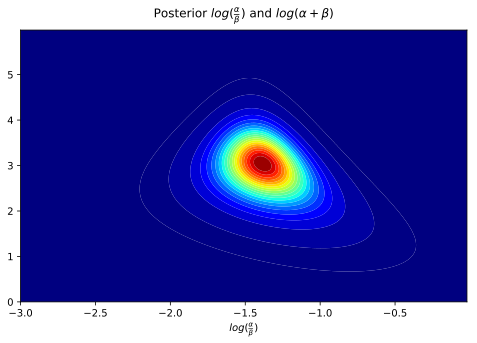

In [26]:
levels = [0, .001, .01] + [.05 * i for i in range(1, 21)]

# plot the posterior level curves
plt.contourf(logit_mu, log_psi, posterior_grid.T, levels=levels, cmap=plt.cm.jet)
plt.xlabel(r'$log(\frac{\alpha}{\beta})$')
# plt.ylabel(r'$log(\alpha + \beta)$')
plt.title(r'Posterior $log(\frac{\alpha}{\beta})$ and', y=1.025)
plt.show()

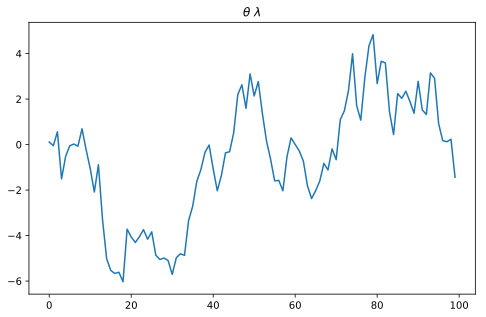